# TF2 로 KMeans 구현

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib.animation

In [2]:
n_points = 200
k = 3
iteration = 100
seed = 123

In [3]:
np.random.seed(seed)
tf.random.set_seed(seed)

# 랜덤 데이터 생성

In [4]:
points = np.random.uniform(0, 10, (n_points, 2))

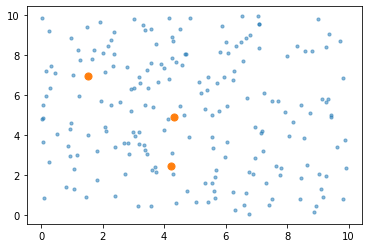

In [8]:
centroids = tf.slice(tf.random.shuffle(points), begin=[0,0], size=[k,-1])   # 초기 임의 centroid 설정
plt.scatter(points[:, 0], points[:, 1], s=10, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1],s=50) # 'kx', markersize=15)    

# 알고리즘 구현

In [9]:

# 가장 근접한 centroid에 개별 point를 할당한다.
def closest_centroids(points, centroids):
    
    # points : (n_points, 2)
    # centroids : (k, 2)
    
    distances = tf.reduce_sum(tf.square(tf.subtract(points, centroids[:,None])), 2)
    assignments = tf.argmin(distances, 0)
    
    return assignments    # (n_points, )

# centroid 재계산
def move_centroids(points, closest, centroids):
    # re-assing된 point들의 평균으로 재설정
    return np.array([points[closest==k].mean(axis=0) for k in range(k)])
    

# 알고리즘 수행

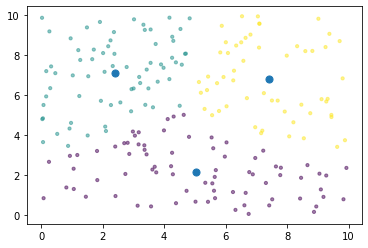

In [12]:
for step in range(iteration):
    closet = closest_centroids(points, centroids)
    centroids = move_centroids(points, closet, centroids)
    
plt.scatter(points[:, 0], points[:, 1], c=closet, s=10, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1],s=50) # 'kx', markersize=15)    

In [ ]:

def _k_init(X, n_clusters, random_state):
    """Init n_clusters seeds according to k-means++
    It modified for Spherical k-means
    Parameters
    -----------
    X : sparse matrix, shape (n_samples, n_features)
    n_clusters : integer
        The number of seeds to choose
    random_state : numpy.RandomState
        The generator used to initialize the centers.
    Notes
    -----
    Selects initial cluster centers for k-mean clustering in a smart way
    to speed up convergence. see: Arthur, D. and Vassilvitskii, S.
    "k-means++: the advantages of careful seeding". ACM-SIAM symposium
    on Discrete algorithms. 2007
    Version ported from http://www.stanford.edu/~darthur/kMeansppTest.zip,
    which is the implementation used in the aforementioned paper.
    """

    n_samples, n_features = X.shape
    centers = np.empty((n_clusters, n_features), dtype=X.dtype)
    random_state = check_random_state(random_state)

    # Set the number of local seeding trials if none is given
    # This is what Arthur/Vassilvitskii tried, but did not report
    # specific results for other than mentioning in the conclusion
    # that it helped.

    # Pick first center randomly
    center_id = random_state.randint(n_samples)
    centers[0] = X[center_id].toarray()

    # Initialize list of closest distances and calculate current potential
    closest_dist_sq = cosine_distances(centers[0, np.newaxis], X)[0] ** 2
    current_pot = closest_dist_sq.sum()

    # Pick the remaining n_clusters-1 points
    for c in range(1, n_clusters):
        # Choose center candidates by sampling with probability proportional
        # to the squared distance to the closest existing center
        rand_vals = random_state.random_sample() * current_pot
        candidate_ids = np.searchsorted(stable_cumsum(closest_dist_sq),
                                        rand_vals)

        centers[c] = X[candidate_ids].toarray()

        # Compute distances to center candidates
        new_dist_sq = cosine_distances(X[candidate_ids, :], X)[0] ** 2
        closest_dist_sq = np.minimum(new_dist_sq, closest_dist_sq)
        current_pot = closest_dist_sq.sum()

    return centers